# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# EDA and Preprocessing

In [30]:
file_path = 'stock.csv' 
data = pd.read_csv(file_path)

In [17]:
data.head()

date       open       high        low      close   adjclose  volume  \
0  2022-01-03  17.799999  18.219000  17.500000  17.760000  17.760000  106600   
1  2022-01-04  17.700001  18.309999  17.620001  17.660000  17.660000  128700   
2  2022-01-05  17.580000  17.799999  16.910000  16.950001  16.950001  103100   
3  2022-01-06  16.650000  16.879999  16.139999  16.170000  16.170000  173600   
4  2022-01-07  16.219999  16.290001  15.630000  15.710000  15.710000  137800   

  ticker  RSIadjclose15  RSIvolume15  ...  high-15  K-15  D-15  \
0   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
1   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
2   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
3   ASLE            NaN          NaN  ...      NaN   NaN   NaN   
4   ASLE            NaN          NaN  ...      NaN   NaN   NaN   

   stochastic-k-15  stochastic-d-15  stochastic-kd-15  volumenrelativo  \
0              NaN              NaN               NaN         0.919758   
1              NaN              NaN               NaN         1.110440   
2              NaN              NaN               NaN         0.889560   
3              NaN              NaN               NaN         1.497843   
4              NaN              NaN               NaN         1.188956   

       diff  INCREMENTO  TARGET  
0 -1.900001   -9.664295       0  
1 -1.379999   -7.247895       0  
2 -0.930000   -5.201344       0  
3 -0.360000   -2.177856       0  
4 -0.120000   -0.758054       0  

[5 rows x 1285 columns]

In [31]:
drop_columns = ['date', 'ticker']
data = data.drop(columns=drop_columns, errors='ignore')

print("\nMissing value count:")
print(data.isnull().sum())


Missing value count:
open                  0
high                  0
low                   0
close                 0
adjclose              0
                   ... 
stochastic-kd-15    587
volumenrelativo     215
diff                155
INCREMENTO          155
TARGET                0
Length: 1283, dtype: int64


In [32]:
data.fillna(data.median(), inplace=True)

In [33]:
assert data.isnull().sum().sum() == 0, "Missing values still exist!"

In [34]:
X = data.drop(columns=['TARGET'])
y = data['TARGET']

In [22]:
y.value_counts()

TARGET
0    6357
1    1424
Name: count, dtype: int64

In [23]:
print("Checking for NaN values:", np.any(np.isnan(X)))
print("Checking for Infinity values:", np.any(np.isinf(X)))
print("Maximum value in X:", np.max(X))
print("Minimum value in X:", np.min(X))


Checking for NaN values: False
Checking for Infinity values: True
Maximum value in X: inf
Minimum value in X: -inf


In [35]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)


In [25]:
print(X.dtypes)


open                float64
high                float64
low                 float64
close               float64
adjclose            float64
                     ...   
stochastic-d-15     float64
stochastic-kd-15    float64
volumenrelativo     float64
diff                float64
INCREMENTO          float64
Length: 1282, dtype: object


In [36]:
X = X.select_dtypes(include=[np.number])


In [41]:
X_df = pd.DataFrame(X, columns=['INCREMENTO', 'diff'])

In [42]:
scaler = StandardScaler()
X_t = scaler.fit_transform(X_df)

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
import joblib
joblib.dump(scaler, 'stock_scaler.pkl')

['stock_scaler.pkl']

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

print("Distribution of target variable after balancing:")
print(y_balanced.value_counts())

Distribution of target variable after balancing:
TARGET
0    6357
1    6357
Name: count, dtype: int64


In [25]:
X_balanced_df = pd.DataFrame(X_balanced, columns=X.columns)

X_balanced_df['TARGET'] = y_balanced.values

X_balanced_df.to_csv('stock_balanced_dataset.csv', index=False)

In [2]:
file_path = 'stock_balanced_dataset.csv' 
data = pd.read_csv(file_path)



# Initial Model Training and Feature Selection

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                       verbose=1)

In [19]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [20]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.9556840077071291

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1272
           1       1.00      0.76      0.86       285

    accuracy                           0.96      1557
   macro avg       0.97      0.88      0.92      1557
weighted avg       0.96      0.96      0.95      1557



In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = 10 


Confusion Matrix:
[[1272    0]
 [  69  216]]


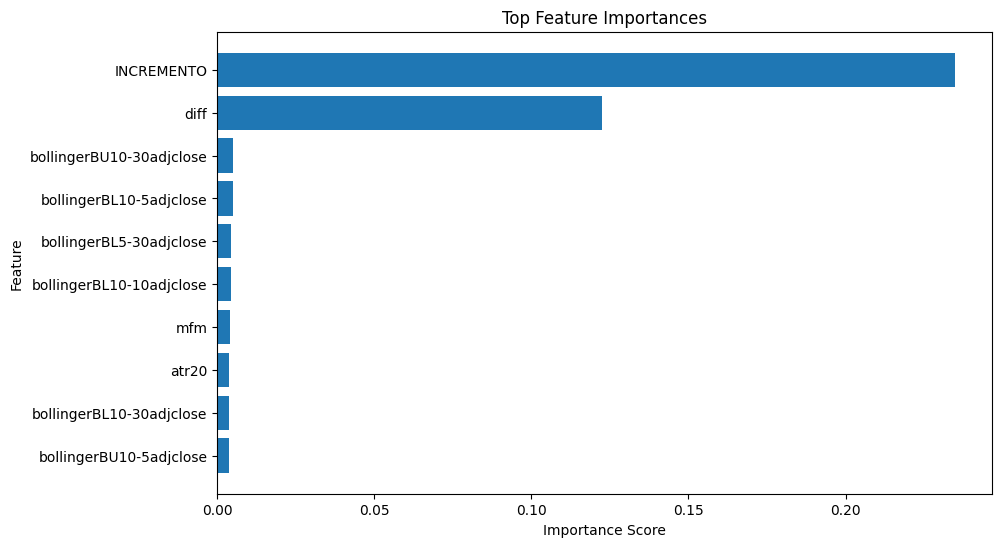

In [22]:
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx][:top_features], feature_importances[sorted_idx][:top_features])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [23]:
# Save the model for future use
import joblib
joblib.dump(model, 'stock_prediction_model_RFC.pkl')

['stock_prediction_model_RFC.pkl']

In [24]:
tf = ['INCREMENTO', 'diff', 'bollingerBU10-30adjclose', 'bollingerBL10-5adjclose', 'bollingerBL5-30adjclose', 'bollingerBL10-10adjclose', 'mfm', 'atr20', 'bollingerBL10-30adjclose', 'bollingerBU10-5adjclose']

In [3]:
tf = ['INCREMENTO', 'diff']

In [4]:
bd = pd.read_csv('stock_balanced_dataset.csv')

In [41]:
len(bd['bollingerBU10-30adjclose'].unique())

12253

In [5]:
bd = bd[tf]

In [6]:
bd.head()

INCREMENTO      diff
0   -0.026499 -0.226637
1   -0.017400 -0.155015
2   -0.009694 -0.093036
3    0.001691 -0.014528
4    0.007038  0.018528

In [8]:
X = bd
y = data['TARGET']

In [46]:
scaler2 = StandardScaler()
scaler2.fit(X)  # Only an approximation!
original_data = scaler2.inverse_transform(X)

In [47]:
original_data = pd.DataFrame(original_data, columns=X.columns)

In [48]:
original_data.head()

INCREMENTO      diff  bollingerBU10-30adjclose  bollingerBL10-5adjclose  \
0    0.005292 -0.080093                 -0.100479                 0.108756   
1    0.012428  0.007527                 -0.100479                 0.108756   
2    0.018472  0.083352                 -0.100479                 0.108756   
3    0.027400  0.179398                 -0.100479                 0.108756   
4    0.031593  0.219838                 -0.100479                 0.108756   

   bollingerBL5-30adjclose  bollingerBL10-10adjclose       mfm     atr20  \
0                 0.105533                  0.105022  0.096660 -0.188519   
1                 0.105533                  0.105022  0.084463 -0.188889   
2                 0.105533                  0.105022  0.083940 -0.186693   
3                 0.105533                  0.105022  0.083763 -0.185626   
4                 0.071021                  0.105022  0.087004 -0.186522   

   bollingerBL10-30adjclose  bollingerBU10-5adjclose  
0                  0.102712                -0.097342  
1                  0.102712                -0.097342  
2                  0.102712                -0.097342  
3                  0.102712                -0.097342  
4                  0.102712                -0.097342

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
rfc_2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1, verbose=1)
rfc_2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                       verbose=1)

In [32]:
# Step 5: Model Evaluation
# Predict on test data
y_pred = rfc_2.predict(X_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [33]:
# Evaluate performance
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.9996067636649626

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1272
           1       1.00      1.00      1.00      1271

    accuracy                           1.00      2543
   macro avg       1.00      1.00      1.00      2543
weighted avg       1.00      1.00      1.00      2543



In [49]:
# Save the model for future use
import joblib
joblib.dump(model, 'stock_prediction_model_RFC_2.pkl')

['stock_prediction_model_RFC_2.pkl']

# Final model

In [10]:
rfc_3 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1, verbose=1)
rfc_3.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                       verbose=1)

In [11]:
# Step 5: Model Evaluation
# Predict on test data
y_pred = rfc_3.predict(X_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
# Evaluate performance
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.9996067636649626

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1272
           1       1.00      1.00      1.00      1271

    accuracy                           1.00      2543
   macro avg       1.00      1.00      1.00      2543
weighted avg       1.00      1.00      1.00      2543



In [14]:
# Save the model for future use
import joblib
joblib.dump(rfc_3, 'stock_prediction_model_RFC_3.pkl')

['stock_prediction_model_RFC_3.pkl']